In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as tt
import torchvision.models as models

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.utils import make_grid
from tqdm.notebook import tqdm


%matplotlib inline

In [2]:
project_name = 'pneumonia-detection-from-chest-xray'

# Preparing the Data

In [3]:
# transformations

# stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # fill this using mean and SD of the 2 channels
train_transf = tt.Compose([
    tt.RandomResizedCrop(224),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
#     tt.Normalize(*stats,inplace=True)
])

# No need to flip and apply other transformations as we will evaluate the model on this set
test_transf = tt.Compose([
    tt.RandomResizedCrop(224),
    tt.ToTensor()
])

val_transf = tt.Compose([
    tt.RandomResizedCrop(224), 
    tt.ToTensor(),
])

In [4]:
train_data = ImageFolder('../input/chest-xray-pneumonia/chest_xray/train', transform=train_transf)

test_data = ImageFolder('../input/chest-xray-pneumonia/chest_xray/test', transform=test_transf)

val_data = ImageFolder('../input/chest-xray-pneumonia/chest_xray/val', transform=val_transf)

In [5]:
# creating DataLoaders
batch_size = 128
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=3, pin_memory=True)

In [6]:
# viewing a sample of the dataset

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()
    
def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images,padding=25)
    imshow(img, title=["NORMAL" if x==0  else "PNEUMONIA" for x in labels])

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

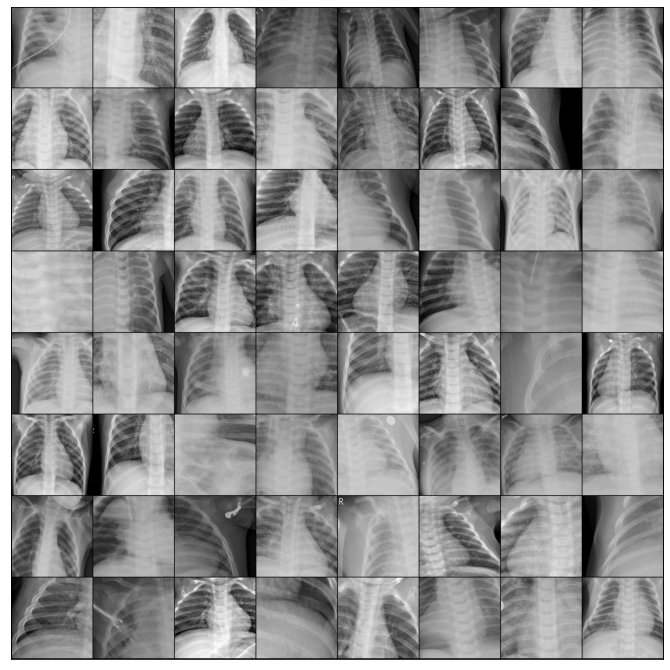

In [7]:
show_batch(train_dl)

# for i in range(1):
#     show_batch_images(train_dl)

In [8]:
# checkin image shape and other statistics
data_iter = iter(train_dl)
img, label = data_iter.next()

print('Image Batch Shape: ', img.shape) # shape of a batch of images
print('Single Image Shape: ', img[1].shape)
print(label[1].item())

print('Classes in training set: ', train_data.classes)
print('Classes in validation set: ', val_data.classes)

Image Batch Shape:  torch.Size([128, 3, 224, 224])
Single Image Shape:  torch.Size([3, 224, 224])
1
Classes in training set:  ['NORMAL', 'PNEUMONIA']
Classes in validation set:  ['NORMAL', 'PNEUMONIA']


## Model and Training

In [9]:
def F_score(output, label, threshold=0.5, beta=1):
    prob = output > threshold
    label = label > threshold

    TP = (prob & label).sum(1).float()
    TN = ((~prob) & (~label)).sum(1).float()
    FP = (prob & (~label)).sum(1).float()
    FN = ((~prob) & label).sum(1).float()

    precision = torch.mean(TP / (TP + FP + 1e-12))
    recall = torch.mean(TP / (TP + FN + 1e-12))
    F2 = (1 + beta**2) * precision * recall / (beta**2 * precision + recall + 1e-12)
    return F2.mean(0)

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = accuracy(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [12]:
class ImageClassificationBase_FScore(nn.Module):
    def training_step(self, batch):
        images, targets = batch 
        out = self(images)                      
        loss = F.cross_entropy(out, targets)      
        return loss
    
    def validation_step(self, batch):
        images, targets = batch 
        out = self(images)                           # Generate predictions
        loss = F.cross_entropy(out, targets)  # Calculate loss
        score = F_score(out, targets)
        return {'val_loss': loss.detach(), 'val_score': score.detach() }
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_scores = [x['val_score'] for x in outputs]
        epoch_score = torch.stack(batch_scores).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_score': epoch_score.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_score: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_score']))

In [13]:
class Resnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.network.parameters():
            param.require_grad = False
        for param in self.network.fc.parameters():
            param.require_grad = True
    
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.network.parameters():
            param.require_grad = True

In [14]:
# Model 2: mobilenet
class Mobilenet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.mobilenet_v2(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.classifier[1].in_features
        self.network.classifier[1] = nn.Linear(num_ftrs, 2)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [16]:
device = get_default_device()
device

device(type='cuda')

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [18]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [19]:
model = to_device(Mobilenet(), device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth


In [20]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 0.6959826350212097, 'val_score': 0.4375}]

In [21]:
# model.freeze()

In [22]:
epochs = 10
max_lr = 0.01
grad_clip = 0.2
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [23]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0027, train_loss: 0.4208, val_loss: 0.7785, val_score: 0.5000



Epoch [1], last_lr: 0.0076, train_loss: 0.4093, val_loss: 0.7511, val_score: 0.5625



Epoch [2], last_lr: 0.0100, train_loss: 0.4361, val_loss: 0.5700, val_score: 0.7500



Epoch [3], last_lr: 0.0095, train_loss: 0.4342, val_loss: 0.8059, val_score: 0.5000



Epoch [4], last_lr: 0.0081, train_loss: 0.4130, val_loss: 0.8777, val_score: 0.3750



Epoch [5], last_lr: 0.0061, train_loss: 0.4203, val_loss: 0.8125, val_score: 0.5000



Epoch [6], last_lr: 0.0039, train_loss: 0.4125, val_loss: 0.7971, val_score: 0.5000



Epoch [7], last_lr: 0.0019, train_loss: 0.3941, val_loss: 0.8027, val_score: 0.5000



Epoch [8], last_lr: 0.0005, train_loss: 0.3843, val_loss: 0.7498, val_score: 0.5625



Epoch [9], last_lr: 0.0000, train_loss: 0.3772, val_loss: 0.6928, val_score: 0.6250
CPU times: user 52.2 s, sys: 26 s, total: 1min 18s
Wall time: 19min 27s


In [24]:
# model.unfreeze()

In [25]:
%%time
history += fit_one_cycle(epochs, 0.001, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], last_lr: 0.0003, train_loss: 0.3768, val_loss: 0.7564, val_score: 0.5625



Epoch [1], last_lr: 0.0008, train_loss: 0.3771, val_loss: 0.7463, val_score: 0.5625



Epoch [2], last_lr: 0.0010, train_loss: 0.3796, val_loss: 0.7596, val_score: 0.5625



Epoch [3], last_lr: 0.0010, train_loss: 0.3768, val_loss: 0.6883, val_score: 0.6250



Epoch [4], last_lr: 0.0008, train_loss: 0.3785, val_loss: 0.7197, val_score: 0.5625



Epoch [5], last_lr: 0.0006, train_loss: 0.3781, val_loss: 0.7329, val_score: 0.5625



Epoch [6], last_lr: 0.0004, train_loss: 0.3687, val_loss: 0.7022, val_score: 0.6250



Epoch [7], last_lr: 0.0002, train_loss: 0.3714, val_loss: 0.6921, val_score: 0.6250



Epoch [8], last_lr: 0.0000, train_loss: 0.3653, val_loss: 0.6641, val_score: 0.6250



Epoch [9], last_lr: 0.0000, train_loss: 0.3603, val_loss: 0.6938, val_score: 0.6250
CPU times: user 51.8 s, sys: 25.6 s, total: 1min 17s
Wall time: 19min 12s


In [26]:
def plot_scores(history):
    scores = [x['val_score'] for x in history]
    plt.plot(scores, '-x')
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.title('Accuracy vs. No. of epochs');

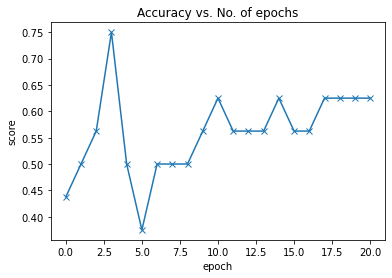

In [27]:
plot_scores(history)

In [28]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

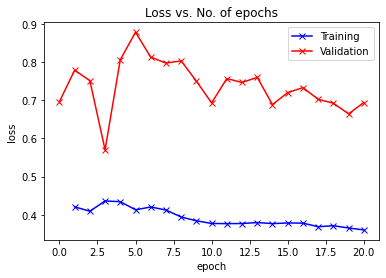

In [29]:
plot_losses(history)

In [30]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

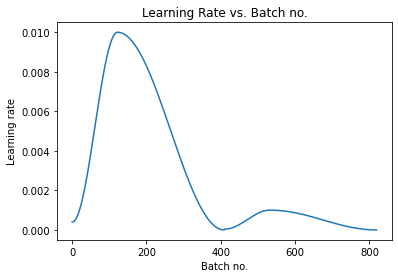

In [31]:
plot_lrs(history)

## Making Prediction

In [32]:
def show_sample(img, target):
    plt.imshow(img.permute(1, 2, 0))
    print('Labels:', decode_target(target, text_labels=True))

In [33]:
labels = {
    0: 'Normal',
    1: 'Pneumonia'
}

In [34]:
def encode_label(label):
    target = torch.zeros(10)
    for l in str(label).split(' '):
        target[int(l)] = 1.
    return target

def decode_target(target, text_labels=False, threshold=0.5):
    result = []
    for i, x in enumerate(target):
        if (x >= threshold):
            if text_labels:
                result.append(labels[i] + "(" + str(i) + ")")
            else:
                result.append(str(i))
    return ' '.join(result)

In [35]:
def predict_single(image):
    xb = image.unsqueeze(0)
    xb = to_device(xb, device)
    preds = model(xb)
    prediction = preds[0]
    print("Prediction: ", prediction)
    show_sample(image, prediction)

Prediction:  tensor([9.9999e-01, 7.2440e-06], device='cuda:0', grad_fn=<SelectBackward>)
Labels: Normal(0)


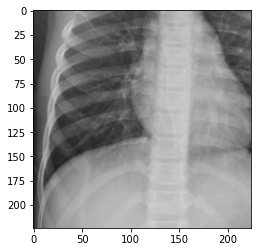

In [36]:
predict_single(test_data[100][0])

Prediction:  tensor([0.0106, 0.9889], device='cuda:0', grad_fn=<SelectBackward>)
Labels: Pneumonia(1)


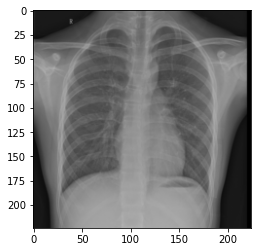

In [37]:
predict_single(test_data[89][0])

In [38]:
@torch.no_grad()
def predict_dl(dl, model):
    torch.cuda.empty_cache()
    batch_probs = []
    for xb, _ in tqdm(dl):
        probs = model(xb)
        batch_probs.append(probs.cpu().detach())
    batch_probs = torch.cat(batch_probs)
    return [decode_target(x) for x in batch_probs]

In [39]:
test_dl = DataLoader(test_data, batch_size, num_workers=3, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [40]:
test_preds = predict_dl(test_dl, model)

## Logging data to Jovian

In [47]:
!pip install jovian --upgrade -q
import jovian

In [48]:
# jovian.log_dataset(dataset_url='https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia')

In [52]:
jovian.reset()
jovian.log_hyperparams(arch='mobilenet', 
                       epochs=epochs, 
                       lr=max_lr, 
                       scheduler='one-cycle', 
                       weight_decay=weight_decay, 
                       grad_clip=grad_clip,
                       opt=opt_func.__name__)

[jovian] Hyperparams logged.


In [53]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_score'],
                   train_loss=history[-1]['train_loss'])

[jovian] Metrics logged.


## Uploading to Jovian

In [ ]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/ak1608759/pneumonia-detection-from-chest-xray


<IPython.core.display.Javascript object>